In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from skimage.io import imsave
from google.colab import drive


In [2]:
# ドライブにマウント
drive.mount('/content/drive', force_remount=True)
drive_path = '/content/drive/MyDrive/20230406_modeAnalysis' # @param{type:"string"}
os.chdir(drive_path)

Mounted at /content/drive


# データの読み込み

In [3]:
#@markdown  /data 内のフォルダ名
sample = '001' # @param{type:"string"}

# データフォルダが存在するか確認
datadir = f"data/{sample}"
assert os.path.exists(datadir), f"path not exists: {datadir}"
# 画像を書き出すフォルダを作成
savedir = f"out/{sample}"
if os.path.exists(savedir):
    print(f"CHECK! Savedir already exists: {savedir}")
    print('Existing files may be overwritten')
os.makedirs(savedir, exist_ok = True)

CHECK! Savedir already exists: out/001
Existing files may be overwritten


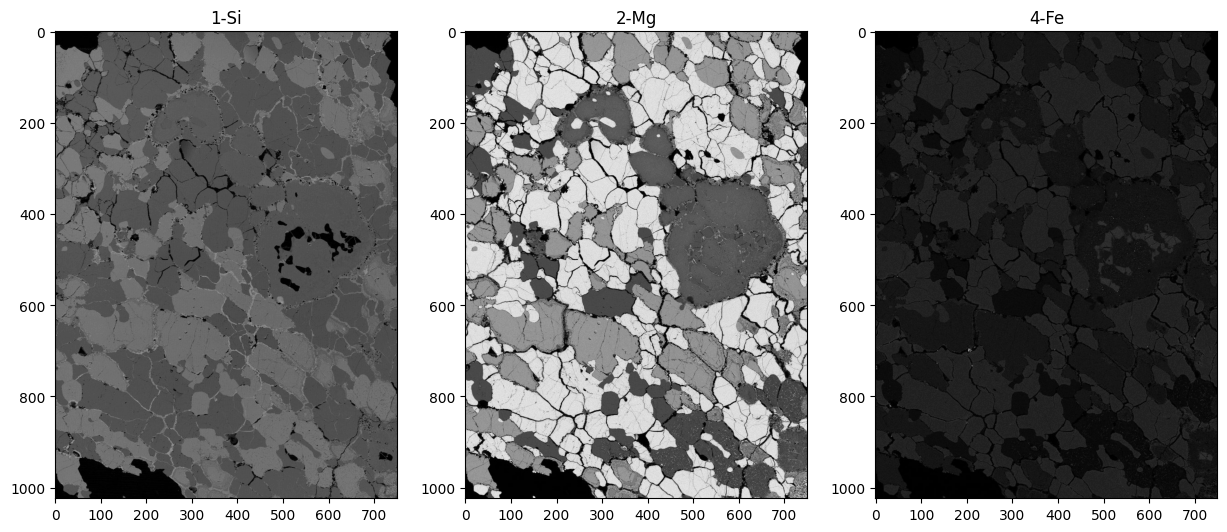

In [4]:
#@markdown  画像のファイル名と同じ名前をリスト形式で
elements = ['1-Si', '2-Mg', '4-Fe'] # @param{type:"raw"}
#@markdown  画像ファイルの拡張子
ext = '.jpg' # @param{type:"string"}

# データを取得して画像で表示
fig, ax = plt.subplots(1, len(elements), figsize = (15, 7))
plt.gray()
flatten_arrays = {}

for i, e in enumerate(elements):
    img_path = f"data/{sample}/{e}{ext}"
    assert os.path.exists(img_path), f"path not exists: {img_path}"
    img_k = cv2.imread(img_path, 0)
    flatten_arrays[e] = np.array(img_k).flatten()

    # 1 列で表示する場合
    ax[i].imshow(img_k)
    ax[i].set_title(e)
    ax[i].set_aspect('equal')

plt.show()
df_flat = pd.DataFrame(flatten_arrays)

# 元素比でマッピング

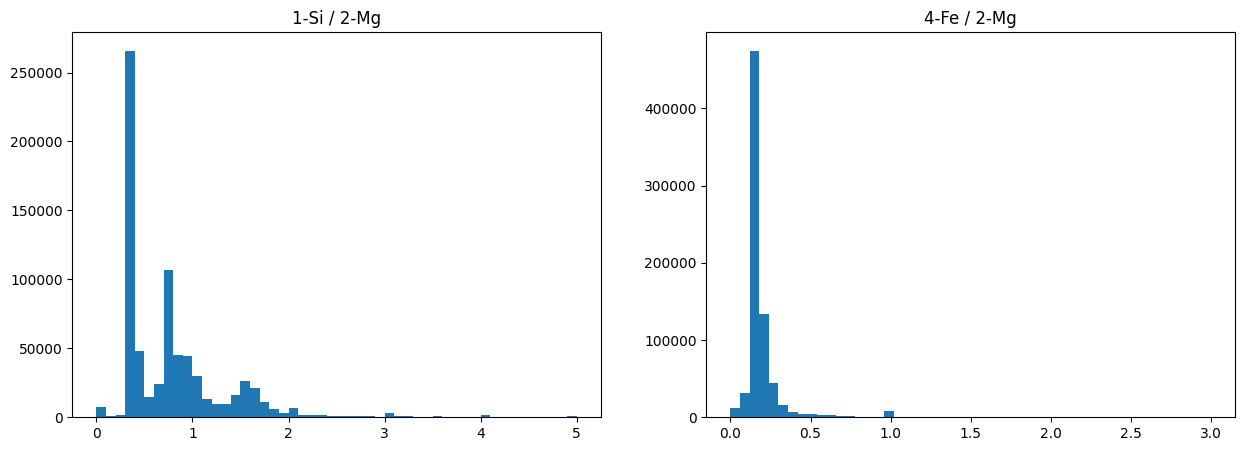

In [5]:
pairs = [('1-Si', '2-Mg'), ('4-Fe', '2-Mg')]
# ヒストグラムを見ながら範囲を決定
ranges = [(0, 5), (0, 3)] # 最初は (0, 255) で設定し，グラフを見ながら絞り込んでいく

###########
fig, ax = plt.subplots(1, len(pairs), figsize = (15, 5))
for i, p in enumerate(pairs):
    ax[i].hist(df_flat[p[0]] / df_flat[p[1]], range=ranges[i], bins=50)
    ax[i].set_title(' / '.join(list(p)))
plt.show()

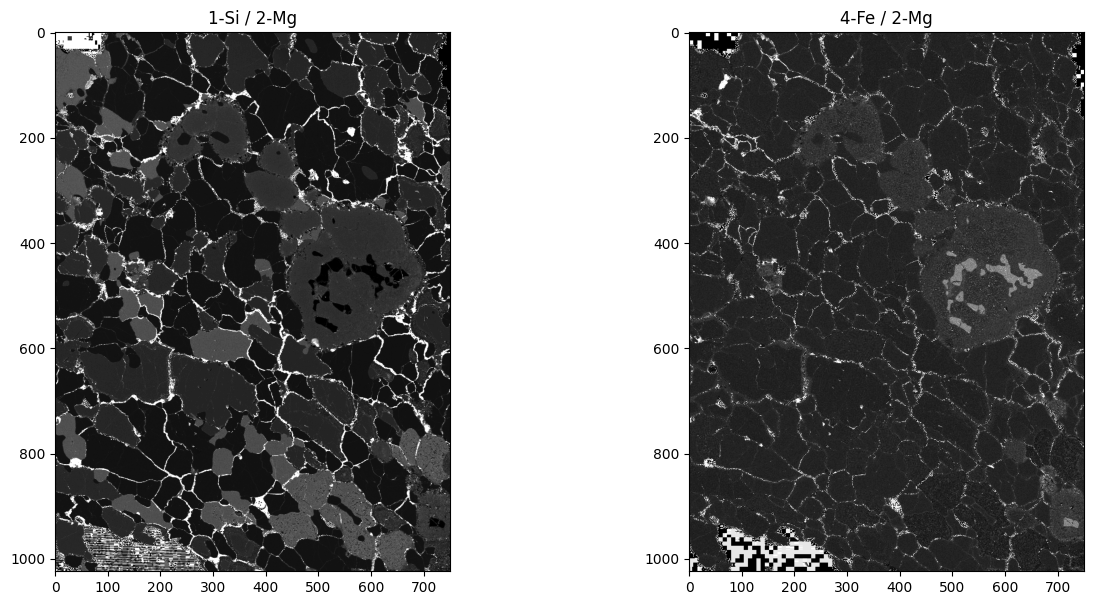

In [6]:
# 元素比のマッピング

ranges = [(0, 5), (0, 1.1)] # 上で決定した範囲，下限は 0 で固定（変更しても画像は変わらないです）

###########

fig, ax = plt.subplots(1, len(pairs), figsize = (15, 7))
plt.gray()
for i, p in enumerate(pairs):
    img_ratio = np.array(df_flat[p[0]] / df_flat[p[1]]).reshape(img_k.shape)
    img_ratio = np.where(img_ratio >= ranges[i][1], ranges[i][1], img_ratio) # 上限値を超えるピクセルを置換
    img_ratio = (img_ratio / ranges[i][1] * 255).astype(np.uint8) # 0~255 までの整数型に変換
    ax[i].imshow(img_ratio)
    ax[i].set_aspect('equal')
    ax[i].set_title(' / '.join(list(p)))
plt.show()

# 鉱物の特定

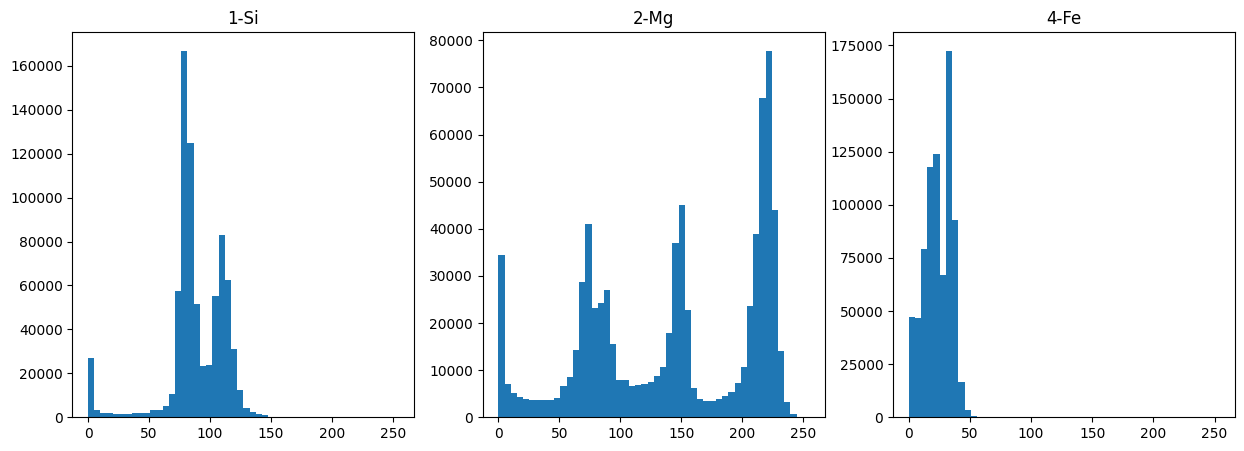

In [7]:
# 元素ごとのヒストグラムを作成
fig, ax = plt.subplots(1, len(elements), figsize = (15, 5))
for i, e in enumerate(elements):
    ax[i].hist(flatten_arrays[e], bins=50)
    ax[i].set_title(e)
plt.show()

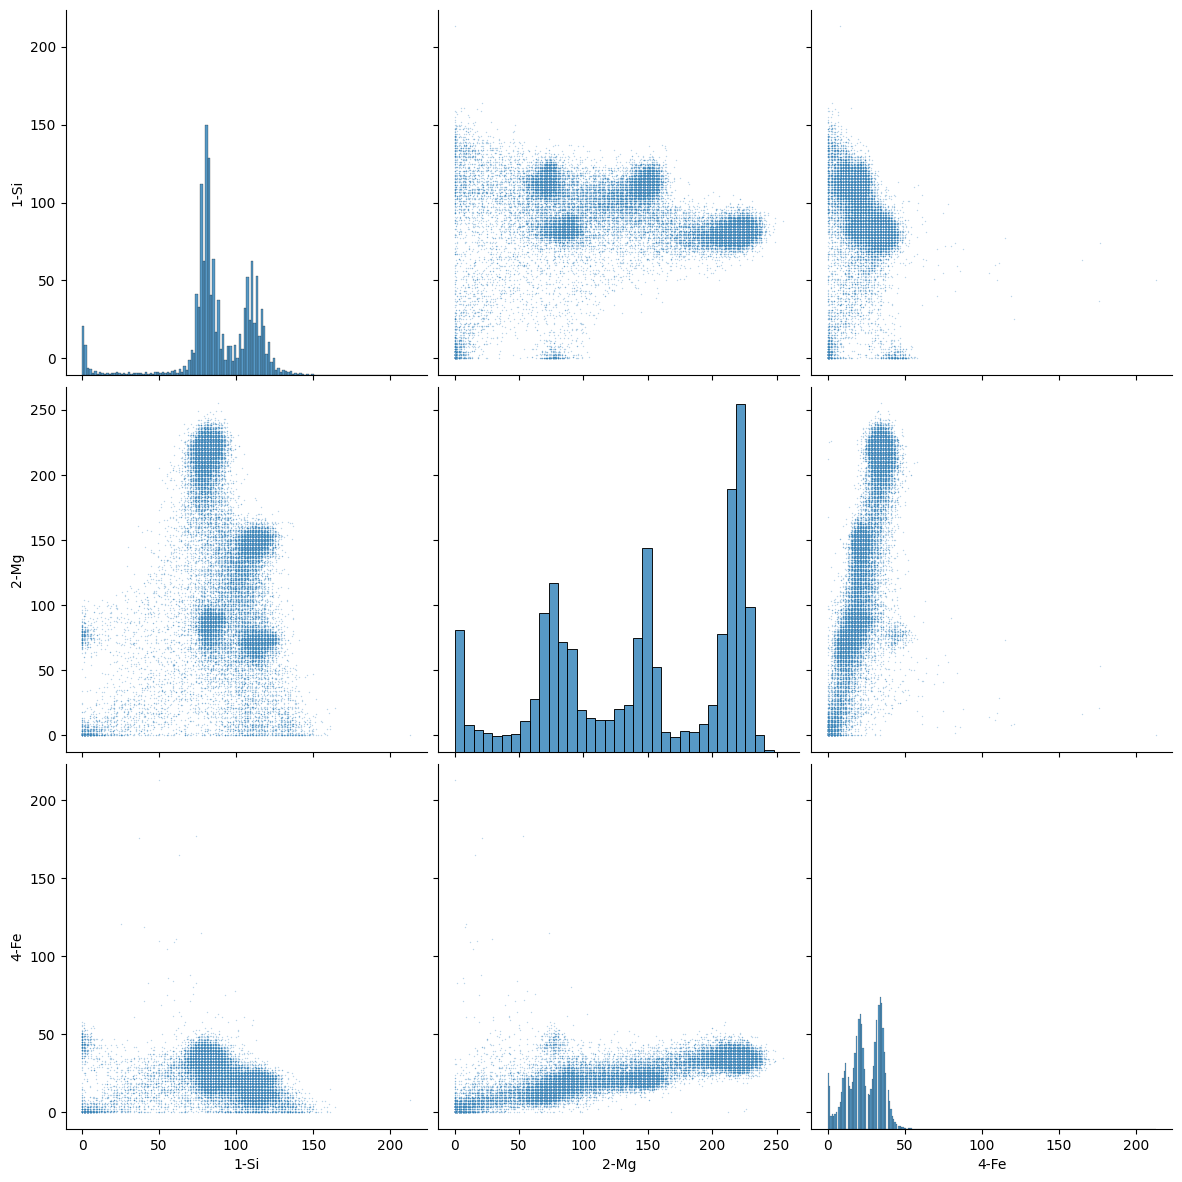

In [8]:
# 相関図を作成．
num_sample = np.array([len(df_flat), 50000]).min() # すべての点で描画すると時間がかかるので，データ点が 50000 点より多い場合にはランダムサンプリングをしてから描画
df_flat = pd.DataFrame(flatten_arrays)
sns.pairplot(df_flat.sample(num_sample), height=4, vars = elements,  plot_kws={"s":1, "alpha": 0.3})

savepath = f"out/{sample}/pairplot1.jpg"
plt.savefig(savepath)
plt.show()

In [9]:
# 比でプロットする場合
# ÷0 の対策が必要？

# df_flat['Si_Mg'] = df_flat['1-Si'] / df_flat['2-Mg']
# df_flat['Mg_Fe'] = df_flat['2-Mg'] / df_flat['4-Fe']
# sns.pairplot(df_flat.sample(num_sample), height=4, vars = ['Si_Mg', 'Mg_Fe'],  plot_kws={"s":1, "alpha": 0.3})


# 手動で閾値を設定して分類

In [10]:
# 分類番号: [元素ごとに (下限, 上限) のペア] を指定
# 下限無しの場合は 0, 上限無しの場合は 255 を入れる
# 基準に重なりがある場合は上の基準が優先されるので，わかりやすく分離できる条件から書いていく

criteria = {
            1: [(0, 25), (0, 10), (0, 5)], # blank, すべての元素濃度が低いもの
            6: [(0, 255), (60, 95), (35, 60)], # Mg-Fe のトレンドから外れるもの                                    
            2: [(0, 255), (175, 255), (0, 255)], # Mg 濃度が最も高いピーク
            3: [(90, 255), (110, 175), (0, 255)], # Mg 濃度が 2 番目に高いピーク
            4: [(50, 95), (60, 110), (0, 255)], # Mg 濃度が 3 番目に高いピークのうち，Si 濃度が低いもの
            5: [(95, 130), (40, 90), (0, 255)], # Mg 濃度が 3 番目に高いピークのうち，Si 濃度が高いもの
            }

###########################

df_flat['type'] = 0 # 未分類
for k, v in criteria.items():
    df_temp = df_flat[df_flat['type'] == 0]
    for i, (min, max) in enumerate(v):
        df_temp = df_temp[(df_temp[elements[i]] >= min) & (df_temp[elements[i]] <= max)]
    df_flat.loc[list(df_temp.index), 'type'] = k

display(df_flat)

,1-Si,2-Mg,4-Fe,type
0,1,0,0,1
1,1,0,0,1
2,1,0,0,1
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
767995,92,186,52,2
767996,89,202,47,2
767997,90,173,54,3
767998,71,186,49,2


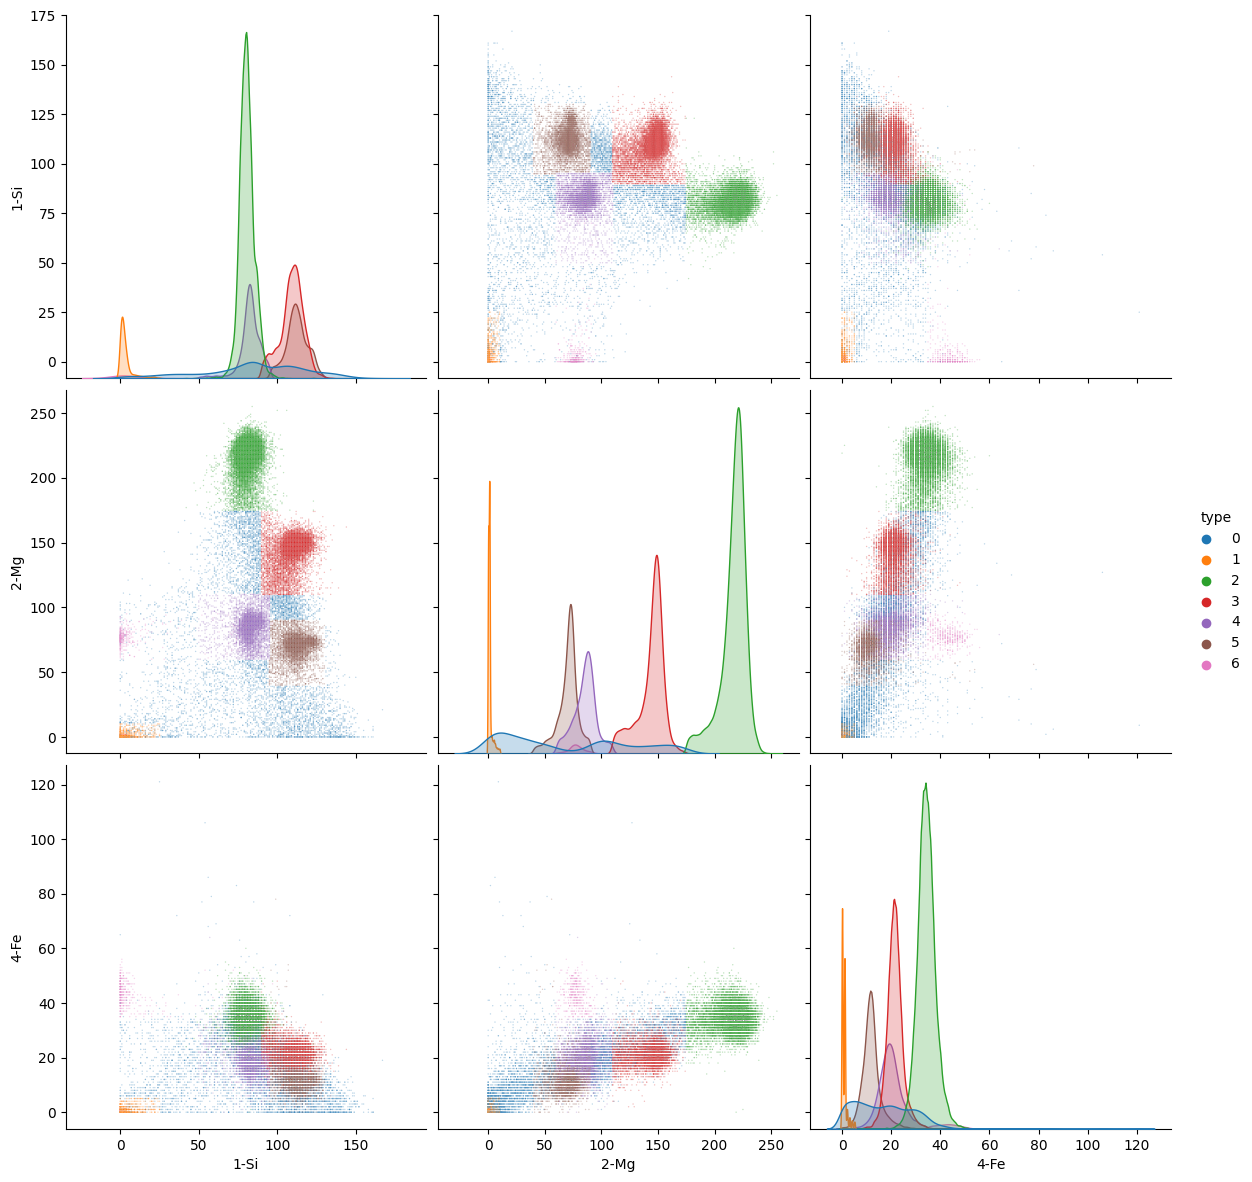

In [11]:
# 色分けした相関図を作成
num_sample = np.array([len(df_flat), 50000]).min() # すべての点で描画すると時間がかかるので，データ点が 50000 点より多い場合にはランダムサンプリングをしてから描画
palette = sns.color_palette(n_colors=len(criteria) + 1)
sns.pairplot(df_flat.sample(num_sample), height=4, vars = elements, hue="type", 
             palette = palette, plot_kws={"s":1, "alpha": 0.3})
savepath = f"out/{sample}/pairplot2.jpg"
plt.savefig(savepath)
plt.show()

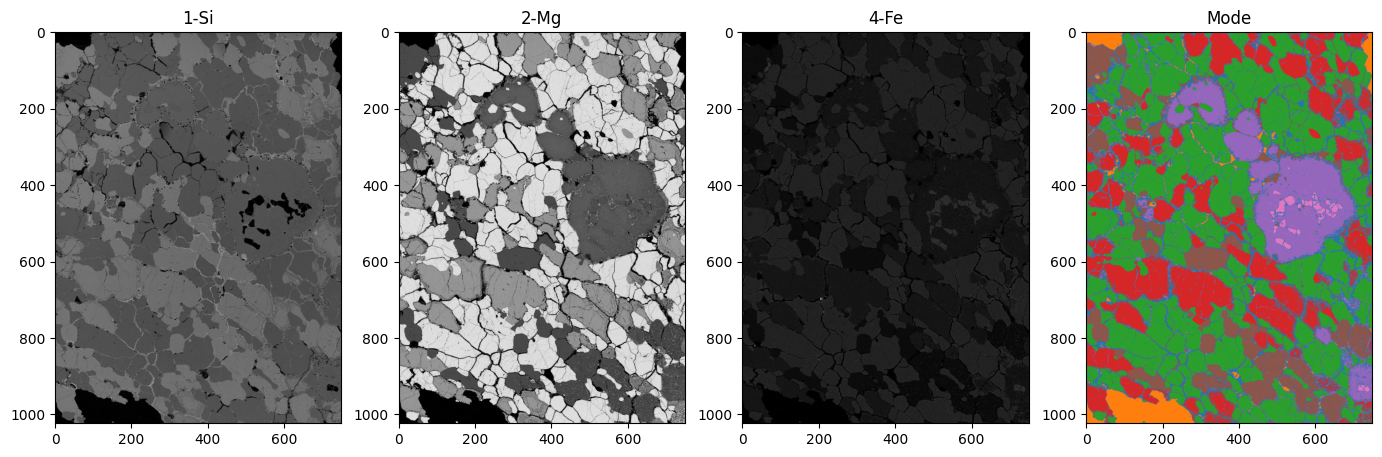

In [12]:
# 画像との対比
# データを取得して画像で表示
fig, ax = plt.subplots(1, len(elements) + 1, figsize = (17, 7))

for i, e in enumerate(elements):
    img_path = f"data/{sample}/{e}{ext}"
    assert os.path.exists(img_path), f"path not exists: {img_path}"
    img = cv2.imread(img_path)
    ax[i].imshow(img)
    ax[i].set_title(e)
    ax[i].set_aspect('equal')

mode = np.zeros_like(cv2.imread(img_path))
mode_k = np.array(df_flat['type']).reshape(mode.shape[:2])
for i, p in enumerate(palette):
    mode[mode_k == i] = (np.array(p) * 255)
ax[len(elements)].imshow(mode)
ax[len(elements)].set_title('Mode')

# Mode 画像だけを保存
imsave(f"out/{sample}/mode1.jpg", mode)

# 元素マップと並べて書き出し
savepath = f"out/{sample}/mode2.jpg"
plt.savefig(savepath)
plt.show()

In [13]:
# 面積割合の算出
valid_criteria = [2, 3, 4, 5, 6] # 分母に含めるクライテリア

num_valid = np.sum(df_flat['type'].isin(valid_criteria))
for k in valid_criteria:
    print(f"criteria {k}: {round(np.sum(df_flat['type'] == k) / num_valid * 100, 1)} %")

criteria 2: 46.6 %
criteria 3: 24.1 %
criteria 4: 13.6 %
criteria 5: 14.8 %
criteria 6: 0.9 %
